In [123]:
%matplotlib inline
from IPython.display import HTML
import numpy as np
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import linear_rainbow
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import sem, t
from scipy.stats.stats import pearsonr
import sys
import statsmodels.stats.api as sms
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.outliers_influence import variance_inflation_factor
import random
import seaborn as sns
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.stats.anova import anova_lm
np.random.seed(123)

# Ordinary Least Squares
In statistics, **ordinary least squares (OLS)** is a type of linear least squares method for estimating the unknown parameters in a linear regression model. OLS chooses the parameters of a linear function of a set of explanatory variables by the principle of least squares: minimizing the sum of the squares of the differences between the observed dependent variable (values of the variable being predicted) in the given dataset and those predicted by the linear function.

Geometrically, this is seen as the sum of the squared distances, parallel to the axis of the dependent variable, between each data point in the set and the corresponding point on the regression surface – the smaller the differences, the better the model fits the data. The resulting estimator can be expressed by a simple formula, especially in the case of a simple linear regression, in which there is a single regressor on the right side of the regression equation.

With the [Gauss–Markov theorem](https://en.wikipedia.org/wiki/Gauss%E2%80%93Markov_theorem), a linear regression model in which the errors have expectation zero, are uncorrelated and have equal variances, the best linear unbiased estimator (BLUE) of the coefficients is given by the ordinary least squares (OLS) estimator, provided it exists. In other words, the OLS estimator is **consistent** when the regressors are exogenous, and **optimal** in the class of linear unbiased estimators when the errors are homoscedastic and serially uncorrelated. Under these conditions, the method of OLS provides minimum-variance mean-unbiased estimation when the errors have finite variances. Under the additional assumption that the errors are normally distributed, OLS is the maximum likelihood estimator.

### Create Artificial Data

In [124]:
nsample = 200
x = np.linspace(0, 10, nsample)
X = np.column_stack((x, x**2))
beta = np.array([1, 0.1, 10])
e = np.random.normal(size=nsample)
#data needs to have an intercept added
X = sm.add_constant(X)
y = np.dot(X, beta) + e

### Specify the system using matrix notation

Above, we created an [overdetermined system](https://en.wikipedia.org/wiki/Overdetermined_system) where there are more equations (i.e. rows) than unknowns (i.e. independent variables):

$$\sum_{j=1}^{p} X_{ij}\beta_j = y_i,\ (i=1, 2, \dots, n)$$

There are $n$ linear equations in $p$ unknown coefficients, $\beta_1,\beta_2,…,\beta_p$, with $n > p$. (Note: for a linear model as above, not all of $\mathbf X$ contains information on the data points. The first column is populated with ones, $X_{i1} = 1$, only the other columns contain actual data, so here $p = number of regressors + 1$.) This can be written in matrix form as:

$$X\beta=y$$

where,

$$
\mathbf {X}=\begin{bmatrix}
X_{11} & X_{12} & \cdots & X_{1p} \\
X_{21} & X_{22} & \cdots & X_{2p} \\
\vdots & \vdots & \ddots & \vdots \\
X_{n1} & X_{n2} & \cdots & X_{np}
\end{bmatrix} ,
\qquad \boldsymbol \beta = \begin{bmatrix}
\beta_1 \\ \beta_2 \\ \vdots \\ \beta_p \end{bmatrix} ,
\qquad \mathbf y = \begin{bmatrix}
y_1 \\ y_2 \\ \vdots \\ y_n
\end{bmatrix}
$$

Such a system usually has no exact solution, so the goal is instead to find the coefficients **$\beta$** which fit the equations "best", in the sense of solving the quadratic minimization problem:

$$
\hat{\boldsymbol{\beta}} = \underset{\boldsymbol{\beta}}{\operatorname{arg\,min}}\,S(\boldsymbol{\beta})
$$

where the objective function $S$ is given by:

$$
S(\boldsymbol{\beta}) = \sum_{i=1}^n \bigl| y_i - \sum_{j=1}^p X_{ij}\beta_j\bigr|^2 = \bigl\|\mathbf y - \mathbf X \boldsymbol \beta \bigr\|^2
$$

The justification for choosing this criterion depends on several assumptions, which derive from the [Gauss–Markov theorem](https://en.wikipedia.org/wiki/Gauss%E2%80%93Markov_theorem) (more on those assumptions later).

When the assumptions are met, this minimization problem has a unique solution, provided that the $p$ columns of the matrix $\mathbf X$ are **linearly independent**, given by solving the normal equations:

$$(\mathbf X^{\rm T} \mathbf X )\hat{\boldsymbol{\beta}}= \mathbf X^{\rm T} \mathbf y.$$

The matrix $\mathbf {X} ^{\rm {T}}\mathbf {X}$ is known as the [Gramian matrix](https://en.wikipedia.org/wiki/Gramian_matrix) of $ \mathbf {X} $ and possesses several nice properties such as being a [positive semi-definite matrix](https://en.wikipedia.org/wiki/Definiteness_of_a_matrix#Negative-definite,_semidefinite_and_indefinite_matrices). The matrix $\mathbf {X} ^{\rm {T}}\mathbf {y} $ is known as the [moment matrix](https://en.wikipedia.org/wiki/Moment_matrix) of regressand by regressors. Finally, $ {\hat {\boldsymbol {\beta }}}$ is the coefficient vector of the least-squares hyperplane, expressed as:

$$
\hat{\boldsymbol{\beta}}= (\mathbf X^{\rm T} \mathbf X )^{-1} \mathbf X^{\rm T} \mathbf y
$$

We can use numpy to calculate $\hat{\boldsymbol{\beta}}$:

In [125]:
X_T = np.transpose(X)
B_hat = np.dot(np.dot(np.linalg.inv(np.dot(X_T, X)), X_T), y)
B_hat

array([0.89972015, 0.19429952, 9.9890047 ])

Above, we used numpy to calculate $ \hat{\boldsymbol{\beta}}= (\mathbf X^{\rm T} \mathbf X )^{-1} \mathbf X^{\rm T} \mathbf y $. The returned array contains the coefficients for our constant, $X_1$, and $X_2$, respectively.

## Estimation

#### Calculating the fitted values

After we have estimated $\beta$, the fitted values (or predicted values) from the regression will be:

$$
\hat{y} = X\hat\beta = Py
$$

where $P = X(X^{T}X)^{−1}X^T$ is the projection matrix onto the space $V$ spanned by the columns of $X$. This matrix $P$ is also sometimes called the hat matrix because it "puts a hat" onto the variable $y$. 

In [126]:
P = np.dot(np.dot(np.dot(X, np.linalg.inv(np.dot(X_T, X))), X_T), y)
P[:10]

array([0.89972015, 0.93470807, 1.02014423, 1.15602864, 1.34236129,
       1.57914219, 1.86637133, 2.20404871, 2.59217434, 3.03074822])

## Calculating Error and Goodness of Fit
Suppose $b$ is a "candidate" value for the parameter vector $\beta$. The quantity $y_i − x_{i}^{T}b$, called the residual for the i-th observation, measures the vertical distance between the data point $(x_i, y_i)$ and the hyperplane $y = x^{T}b$, and thus assesses the degree of fit between the actual data and the model. The **sum of squared residuals (SSR)** (also called the error sum of squares (ESS) or residual sum of squares (RSS)) is a measure of the overall model fit:

$$
S(b) = \sum_{i=1}^n (y_i - x_i ^\mathrm{T} b)^2 = (y-Xb)^\mathrm{T}(y-Xb)
$$

The value of $b$ which minimizes this sum is called the OLS estimator for $\beta$, which is what we calculated above. Now, let's calculate the SSR by hand:

In [127]:
ssr = np.dot(np.transpose(y - np.dot(X, B_hat)), y - np.dot(X, B_hat))
print(ssr)

219.71901589411047


Another matrix, closely related to $P$ above, is the annihilator matrix $M = I_n − P$ (note that $I_n$ is referring to an [identity matrix](https://en.wikipedia.org/wiki/Identity_matrix)). This is a projection matrix onto the space orthogonal to $V$. Both matrices $P$ and $M$ are symmetric and idempotent and relate to the data matrix $X$ via identities $1=PX = X$ and $MX=0$.

Matrix $M$ creates the residuals from the regression:

$$
\hat\varepsilon = y - \hat y = y - X\hat\beta = My = M(X\beta+\varepsilon) = (MX)\beta + M\varepsilon = M\varepsilon
$$

Using these residuals we can estimate the value of $\sigma^2$, called the [reduced chi-squared](https://en.wikipedia.org/wiki/Reduced_chi-squared_statistic):

$$
s^2 = \frac{\hat\varepsilon ^\mathrm{T} \hat\varepsilon}{n-p} = \frac{(My)^\mathrm{T} My}{n-p} = \frac{y^\mathrm{T} M^\mathrm{T}My}{n-p}= \frac{y ^\mathrm{T} My}{n-p} = \frac{S(\hat\beta)}{n-p},\qquad
    \hat\sigma^2 = \frac{n-p}{n}\;s^2
$$

The numerator, $n−p$, is the [statistical degrees of freedom](https://en.wikipedia.org/wiki/Degrees_of_freedom_(statistics)). The first quantity, $s^2$, is the OLS estimate for $\sigma^2$, whereas the second, $\hat\sigma^2$, is the MLE estimate for $\sigma^2$. The two estimators are quite similar in large samples; the first estimator is always [unbiased](https://en.wikipedia.org/wiki/Bias_of_an_estimator), while the second estimator is biased but has a smaller [mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error). In practice $s^2$ is used more often, since it is more convenient for the hypothesis testing. The square root of $s^2$ is called the regression standard error, standard error of the regression, or standard error of the equation. The value of $s$ provides the absolute measure in the units of the dependent variables of the typical distance that the data points fall from the regression line. Below, we'll caluclate $s$:

In [128]:
n = X.shape[0]
p = X.shape[1]
dof = n - p
eps_hat = y - P
eps_hat_T = np.transpose(eps_hat)
s_2 = np.dot(eps_hat_T, eps_hat) / dof
#regression standard error
s = np.sqrt(s_2)
print(s)

1.0560894629610236


It is common to assess the goodness-of-fit of the OLS regression by comparing how much the initial variation in the sample can be reduced by regressing onto $X$. The coefficient of determination $R^2$ is defined as a ratio of "explained" variance to the "total" variance of the dependent variable $y$:

$$
R^2 = \frac{\sum(\hat y_i-\overline{y})^2}{\sum(y_i-\overline{y})^2} = \frac{y ^\mathrm{T} P ^\mathrm{T} LPy}{y ^\mathrm{T} Ly} = 1 - \frac{y ^\mathrm{T} My}{y ^\mathrm{T} Ly} = 1 - \frac{\rm SSR}{\rm TSS}
$$

where TSS is the total sum of squares for the dependent variable, $L = I_n − 11^T/n$ ($1$ is an $n×1$ vector of ones) and L is a "centering matrix" which is equivalent to regression on a constant; it simply subtracts the mean from a variable. In order for $R^2$ to be meaningful, the matrix $X$ of data on regressors must contain a column vector of ones to represent the constant whose coefficient is the regression intercept. In that case, $R^2$ will always be a number between 0 and 1, with values close to 1 indicating a good degree of fit.

In [129]:
y_bar = np.mean(y)
num = np.sum(np.square(P - y_bar))
denom = np.sum(np.square(y - y_bar))
r_2 = num / denom
print(num, denom, r_2)

17993561.903605234 17993781.62262119 0.9999877891695829


#### Coefficient standard errors
The variance-covariance matrix (or simply covariance matrix) of $\hat {\beta }$ is equal to:

$$
\operatorname{Var}[\, \hat\beta \mid X \,] = \sigma^2(X ^T X)^{-1} = \sigma^2 Q
$$

Once we calculate that, the standard error of each coefficient ${\hat {\beta }}_{j}$ is equal to square root of the j-th diagonal element of this matrix. The estimate of this standard error is obtained by replacing the unknown quantity $\sigma^2$ with its estimate $s^2$. Let's do that below:

In [130]:
Q = np.linalg.inv(np.dot(np.transpose(X), X))
#RuntimeWarning will occur due to negative off-diagonal values
covar = np.sqrt(np.dot(s_2, Q))
std_errs = np.diagonal(covar)
std_errs

/Users/charlessmcallister/.local/share/virtualenvs/learning-data-science-Oygx0A85/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


array([0.22180862, 0.10248138, 0.00991963])

These standard errors estimates of the standard deviations of each coefficient, i.e. the amount each coefficient varies across observsations. It can be thought of as a measure of the precision with which the regression coefficient is measured. 

If a coefficient is large compared to its standard error, then it is probably different from 0. How large is too large? The $t$ statistic, which is the coefficient divided by its standard error, can be compared to [Student's t distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution) to determine a $p$ value, which is the number that you really need to be looking at. 

The Student's t distribution describes how the mean of a sample with a certain number of observations (your $n$) is expected to behave. If 95% of the t distribution is closer to the mean than the t-value on the coefficient you are looking at, then you have a P value of 5%. This is also reffered to a significance level of 5%. The p-value is the probability of seeing a result as extreme as the one you are getting (a t value as large as yours) in a collection of random data in which the variable had no effect.

Below, we'll calculate the t-statisics and p-values for our coeffecients given those standard errors.

In [131]:
ts = B_hat / std_errs
ts

array([   4.05629023,    1.89594953, 1006.99414871])

In [132]:
for err, t_stat in zip(std_errs, ts):
    pval = t.sf(np.abs(t_stat), n-1)*2  # two-sided p-value
    print('stderr:  %6.3f t-statistic = %6.3f pvalue = %6.4f' % (err, t_stat, pval))
    

stderr:   0.222 t-statistic =  4.056 pvalue = 0.0001
stderr:   0.102 t-statistic =  1.896 pvalue = 0.0594
stderr:   0.010 t-statistic = 1006.994 pvalue = 0.0000


Finally, we can calucalte confidence intervals for these standard errors:

In [133]:
for coef, err, t_stat in zip(B_hat, std_errs, ts):
    print(coef, err, t_stat)

0.8997201520803788 0.22180862328896475 4.056290232270428
0.19429952228927938 0.10248137902386163 1.8959495289777368
9.98900469615945 0.009919625361275723 1006.9941487059149


In [134]:
confidence = .95 #alpha = .05
for coef, err, t_stat in zip(B_hat, std_errs, ts):
    pval = t.sf(np.abs(t_stat), n-1)*2  # two-sided p-value
    h = err * t.ppf((1 + confidence) / 2, n - 1)
    start = coef - h
    end = coef + h
    print('stderr:  %6.3f t-statistic = %6.3f pvalue = %6.4f lower_ci = %6.4f upper_ci = %6.4f' % (err, 
                                                                                                   t_stat, 
                                                                                                   pval,
                                                                                                   start,
                                                                                                   end))

stderr:   0.222 t-statistic =  4.056 pvalue = 0.0001 lower_ci = 0.4623 upper_ci = 1.3371
stderr:   0.102 t-statistic =  1.896 pvalue = 0.0594 lower_ci = -0.0078 upper_ci = 0.3964
stderr:   0.010 t-statistic = 1006.994 pvalue = 0.0000 lower_ci = 9.9694 upper_ci = 10.0086


## OLS with Statsmodels
Now that we've calculated the OLS model by hand, let's use statsmodels.

In [135]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.067e+06
Date:                Mon, 22 Apr 2019   Prob (F-statistic):               0.00
Time:                        13:11:28   Log-Likelihood:                -293.19
No. Observations:                 200   AIC:                             592.4
Df Residuals:                     197   BIC:                             602.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8997      0.222      4.056      0.0

In [136]:
print(results.params)
print(B_hat)

[0.89972015 0.19429952 9.9890047 ]
[0.89972015 0.19429952 9.9890047 ]


In [137]:
print(results.bse)
print(std_errs)

[0.22180862 0.10248138 0.00991963]
[0.22180862 0.10248138 0.00991963]


In [138]:
print(results.ssr)
print(ssr)

219.7190158941119
219.71901589411047


As we can see, our calculations came out the same.

# OLS Assumptions
In order for OLS estimates to be valid, we need to make at least 6 assumptions:

1. OLS model is linear in its parameters.
2. Error term has 0 population mean
3. Error term is not correlated with Xs
4. No serial correlation (really only an issue with time series data)
5. No heteroskedasticity 
6. No perfect multicolinearity

Sometimes a 7th optional assumption is added:

7. Error term is normally distributed


Violations of these assumptions can result in things like incorrect signs for your coefficient estimates or unreliable variances for your OLS estimates, leading to confidence intervals that are too wide or too narrow.

That being said, we'll first cover the famous **Gauss-Markov Theorem**, which is where these assumptions come from. Then we'll discuss each assumption in turn.

### The Gauss-Markov Theorem
The Gauss-Markov Theorem is named after Carl Friedrich Gauss and Andrey Markov.

Let the regression model be: $Y={ \beta }_{ o }+{ \beta }_{ i }{ X }_{ i }+\varepsilon$

Under the Gauss-Markov Theorem, the model specified above is the **Best Linear Unbiased Estimators (BLUE)** if, and only if, several assumptions are satisfied. BLUE merely means that the estimated $\beta$ coefficients have the minimum variance of all linear and unbiased estimators of $\beta$. This venn digram illustrates:

<img src="assets/blue.png" width="300">

### 1. The linear regression model is “linear in parameters.”
Consider an equation of the form:

$$
y = \beta_0 + \beta_1x_1 + \beta_2x_2 + \epsilon
$$

where $x$'s are the variables and $\beta$'s are the parameters. Here, $y$ is a linear function of $\beta$'s (linear in parameters) and also a linear function of $x$'s (linear in variables). If you change the equation to

$$
y = \beta_0 + \beta_1x_1 + \beta_2x_1^2 + \epsilon
$$

Then, it is no longer linear in variables (because of the squared term) but it is still linear in parameters. And for (multiple) linear regression, that's all that matters because in the end, you are trying to find a set of $
\beta$'s that minimizes a loss function. For that, you need to solve a system of linear equations (like we did above).
 
To get a better understanding of this, we'll simulate some data with a non-linear relationship between $x$ and $y$. Then we'll fit an OLS non-linear curve that's nevertheless linear in its parameters. 

In [139]:
nsample = 50
sig = 0.5
x1 = np.linspace(0, 20, nsample)
X1 = np.column_stack((x1, np.sin(x1), (x1-5)**2, np.ones(nsample)))
beta = [0.5, 0.5, -0.02, 5.]

y_true = np.dot(X1, beta)
y1 = y_true + sig * np.random.normal(size=nsample)

res = sm.OLS(y1, X1).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     275.9
Date:                Mon, 22 Apr 2019   Prob (F-statistic):           2.10e-29
Time:                        13:11:28   Log-Likelihood:                -26.947
No. Observations:                  50   AIC:                             61.89
Df Residuals:                      46   BIC:                             69.54
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4698      0.023     20.666      0.0

Now we'll graphically compare the true relationship to the OLS predictions. This is commonly called a **residuals-vs-fitted plot**. This graph shows if there are any nonlinear patterns in the residuals, and thus in the data as well. One of the mathematical assumptions in building an OLS model is that the data can be fit by a line. If this assumption holds and our data can be fit by a linear model, then we should see a relatively flat line when looking at the residuals vs fitted.

If the relationship is nonlinear, the residuals will have non-random patterns.

Confidence intervals around the predictions are built using the `wls_prediction_std` command:

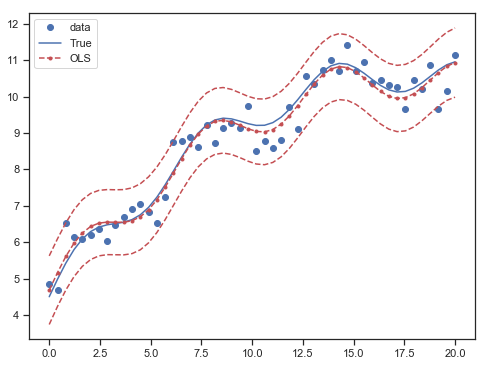

In [140]:
prstd, iv_l, iv_u = wls_prediction_std(res)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(x1, y1, 'o', label="data")
ax.plot(x1, y_true, 'b-', label="True")
ax.plot(x1, res.fittedvalues, 'r--.', label="OLS")
ax.plot(x1, iv_u, 'r--')
ax.plot(x1, iv_l, 'r--')
ax.legend(loc='best');

More formally, you can use the Rainbow Test for the Null hypothesis that the linear specification is correct:

In [141]:
name = ['t value', 'p value']
test = linear_rainbow(res)
print(list(zip(name, test)))

[('t value', 0.9912127048425328), ('p value', 0.5131894359928766)]


### 2. Error term has zero population mean
This is sometimes phrased as the errors having a [conditional mean](https://en.wikipedia.org/wiki/Conditional_expectation) of zero: 

$$\operatorname{E}[\,\varepsilon\mid X\,] = 0$$ 

In other words, each observation should have random error with a mean of 0. This is of couse rarely the case, so that's why a constant term (the intercept) is added to the OLS model. It takes the amount of error that deviates from 0, lallowing us to say $\operatorname{E}[\,\varepsilon\mid X\,] = 0$

### 3. Error term is not correlated with Xs
This is often referred to as **strict exogeneity**, meaning that your independent variables are determined outside of the model. If this assumption is violated, the real cause of changes in your dependent variable might end up in your error term and then inflate (or deflate) the coefficient for one (or more) of your coefficient estimates.

As an example, take this simple OLS model:

$$
y = \beta_0 + \beta_{1}X_{i} + \epsilon_i
$$

Suppose $X_i$ and $\epsilon_i$ are positively correlated, i.e. when $X_i$ is large, $/epsilon_i$ tends to be large. In this case, your plotted line might look like this:

<img src="assets/exog.png" width="300">

Why would $X_i$ and $\epsilon_i$ be positively correlated? And how could that cause your estimated coefficient for $X$ overshoot the true value? As an example, pretend our $y$ is quantity of hamburgers sold across the county and our $X$ is the price of those hamburgers. Our model would be:

$$
sales_i = \beta_0 + \beta_{1}price_{i} + \epsilon_i
$$

The problem with this model is that it's omitted (at least one) very important variable:  **quality**. It's quality much more so than price that drives a person's decision to buy a 1 dollar burger from McDonalds as opposed to a 20 dollar burger from a fancy gastropub. By not including this variable in the model, its effect becomes a part of $\epsilon_i$. Unfortuntely, price and quality are highly correlated. Therefore $x$ and $\epsilon$ are highly correlated. This means the estimate of $\beta_{1}$ will be too high, as you can see in the plot above. 

You can easily calculate the correlation between your error and Xs like this:

In [142]:
error_term = results.resid
for col in range(X.shape[1]):
    if col == 0:
        continue
    _X = X[:,col]
    r, p_value = pearsonr(error_term, _X)
    print(col, r, p_value)

1 -2.1271246713672138e-13 1.0
2 -2.164611624876811e-13 1.0


### 4. No serial correlation
Serial correlation (also called autocorrelation) occurs when the error terms across observations are correlated with one another (i.e. $\epsilon_1$ is correlated with $\epsilon_2$). the errors are uncorrelated between observations: $E[\epsilon_i \epsilon_j \mid X] = 0$ for $i ≠ j$. 


If errors are serially correlated like this, then the error in one period affects the error in the next. This is important to check for in time series data, panel data, cluster samples, hierarchical data, repeated measures data, longitudinal data, and other data with dependencies. In such cases generalized least squares provides a better alternative than the OLS. Another expression for autocorrelation is serial correlation.

### 5. Homoscedasticity
The error should have a constant variance: 
$$E[{\epsilon_i}^2\mid X] = \sigma^2$$ 

This means that the error term should have the same variance $\sigma^2$ in each observation. When this requirement is violated we have heteroscedasticity (i.e. the variance of the error depends on $X$). In such cases a more efficient estimator could be weighted least squares. If the errors have infinite variance then the OLS estimates will also have infinite variance (although by the law of large numbers they will nonetheless tend toward the true values so long as the errors have zero mean). In this case, [robust estimation](https://en.wikipedia.org/wiki/Robust_regression) techniques are recommended.

A good visual way to check for heteroscedasticity is with a Scale-Location plot.

In [143]:
# model values
model_fitted_y = results.fittedvalues
# model residuals
model_residuals = results.resid
# normalized residuals
model_norm_residuals = results.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)
# leverage, from statsmodels internals
model_leverage = results.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
model_cooks = results.get_influence().cooks_distance[0]

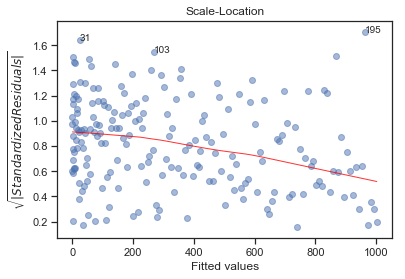

In [144]:
# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]


plot_lm_3 = plt.figure()
plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5);
sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt,
          scatter=False,
          ci=False,
          lowess=True,
          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
plot_lm_3.axes[0].set_title('Scale-Location')
plot_lm_3.axes[0].set_xlabel('Fitted values')
plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

# annotations
abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
for i in abs_norm_resid_top_3:
    plot_lm_3.axes[0].annotate(i,
                             xy=(model_fitted_y[i],
                                 model_norm_residuals_abs_sqrt[i]));

The more horizontal the red line is, the more likely the data is homoscedastic. Heteroscedasticity typically has a sideways “V” shape.

There are also some more formal tests you can run:
 - **Breush-Pagan test** -  tests whether the variance of the errors from a regression is dependent on the values of the independent variables. In that case, heteroskedasticity is present. If the test statistic has a p-value below an appropriate threshold (e.g. p < 0.05) then the null hypothesis of homoskedasticity is rejected and heteroskedasticity assumed.
 - **Goldfeld-Quandt test** - tests whether the variances of the errors of the regression model are not constant, but instead monotonically related to a pre-identified explanatory variable.

In [145]:
name = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(results.resid, results.model.exog)
for i in list(zip(name, test)):
    print(i)

('Lagrange multiplier statistic', 4.406698315033664)
('p-value', 0.11043268186997897)
('f-value', 2.219195546532248)
('f p-value', 0.11140693859000016)


In [146]:
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(results.resid, results.model.exog)
for i in list(zip(name, test)):
    print(i)

('F statistic', 0.7240923028749447)
('p-value', 0.9432070241790471)


Although we don't see much evidence for heteroscedasticity above, the two most common methods of “fixing” heteroscedasticity is using a weighted least squares approach, or using a heteroscedastic-corrected covariance matrix (hccm).

### 6. No perfect multicolinearity
Multicollinearity exists when two or more of the predictors are moderately or highly correlated. Unfortunately, when it exists, it can wreak havoc on our analysis and thereby limit the research conclusions we can draw. As we will soon learn, when multicollinearity exists, any of the following pitfalls can be exacerbated:

 - the estimated regression coefficient of any one variable depends on which other predictors are included in the model
 - the precision of the estimated regression coefficients decreases as more predictors are added to the model
 - the marginal contribution of any one predictor variable in reducing the error sum of squares depends on which other predictors are already in the model
 - hypothesis tests for $\beta_k = 0$ may yield different conclusions depending on which predictors are in the model
 
#### Types of multicollinearity
There are two types of multicollinearity:

 - **Structural multicollinearity** is a mathematical artifact caused by creating new predictors from other predictors — such as, creating the predictor x2 from the predictor x.
 - **Data-based multicollinearity**, on the other hand, is a result of a poorly designed experiment, reliance on purely observational data, or the inability to manipulate the system on which the data are collected.

In the case of structural multicollinearity, the multicollinearity is induced by what you have done. Data-based multicollinearity is the more troublesome of the two types of multicollinearity. Unfortunately it is the type we encounter most often!

Let's take a quick look at an example in which **data-based multicollinearity exists**. Some researchers observed — notice the choice of word! — the following data on 20 individuals with high blood pressure:



Two variables are *perfectly* colinear if one can be determined perfectly by the other. For example, $a$ and $b$ below are perfectly colinear:

In [147]:
bp = pd.read_csv('assets/blood.txt',
                 delim_whitespace=True)

bp

,Pt,BP,Age,Weight,BSA,Dur,Pulse,Stress
0,1,105,47,85.4,1.75,5.1,63,33
1,2,115,49,94.2,2.10,3.8,70,14
2,3,116,49,95.3,1.98,8.2,72,10
3,4,117,50,94.7,2.01,5.8,73,99
4,5,112,51,89.4,1.89,7.0,72,95
5,6,121,48,99.5,2.25,9.3,71,10
6,7,121,49,99.8,2.25,2.5,69,42
7,8,110,47,90.9,1.90,6.2,66,8
8,9,110,49,89.2,1.83,7.1,69,62
9,10,114,48,92.7,2.07,5.6,64,35


Here's a description of the variables:
 - blood pressure ($y = BP$, in mm Hg)
 - age ($x_1$ = Age, in years)
 - weight ($x_2$ = Weight, in kg)
 - body surface area ($x_3$ = BSA, in sq m)
 - duration of hypertension ($x_4$ = Dur, in years)
 - basal pulse ($x_5$ = Pulse, in beats per minute)
 - stress index ($x_6$ = Stress)
 
The researchers were interested in determining if a relationship exists between blood pressure and age, weight, body surface area, duration, pulse rate and/or stress level. We can create a correlation matrix to help us see which variables are correlated with B (as well as with each other):

In [148]:
bp[[x for x in bp.columns if x != 'Pt']].corr()

,BP,Age,Weight,BSA,Dur,Pulse,Stress
BP,1.000000,0.659093,0.950068,0.865879,0.292834,0.721413,0.163901
Age,0.659093,1.000000,0.407349,0.378455,0.343792,0.618764,0.368224
Weight,0.950068,0.407349,1.000000,0.875305,0.200650,0.659340,0.034355
BSA,0.865879,0.378455,0.875305,1.000000,0.130540,0.464819,0.018446
Dur,0.292834,0.343792,0.200650,0.130540,1.000000,0.401514,0.311640
Pulse,0.721413,0.618764,0.659340,0.464819,0.401514,1.000000,0.506310
Stress,0.163901,0.368224,0.034355,0.018446,0.311640,0.506310,1.000000


Blood pressure appears to be related fairly strongly to Weight (r = 0.950) and BSA (r = 0.866), and hardly related at all to Stress level (r = 0.164). And, Weight and BSA appear to be strongly related (r = 0.875), while Stress and BSA appear to be hardly related at all (r = 0.018). The high correlation among some of the predictors suggests that data-based multicollinearity exists. We can see that more directly with a pairplot:

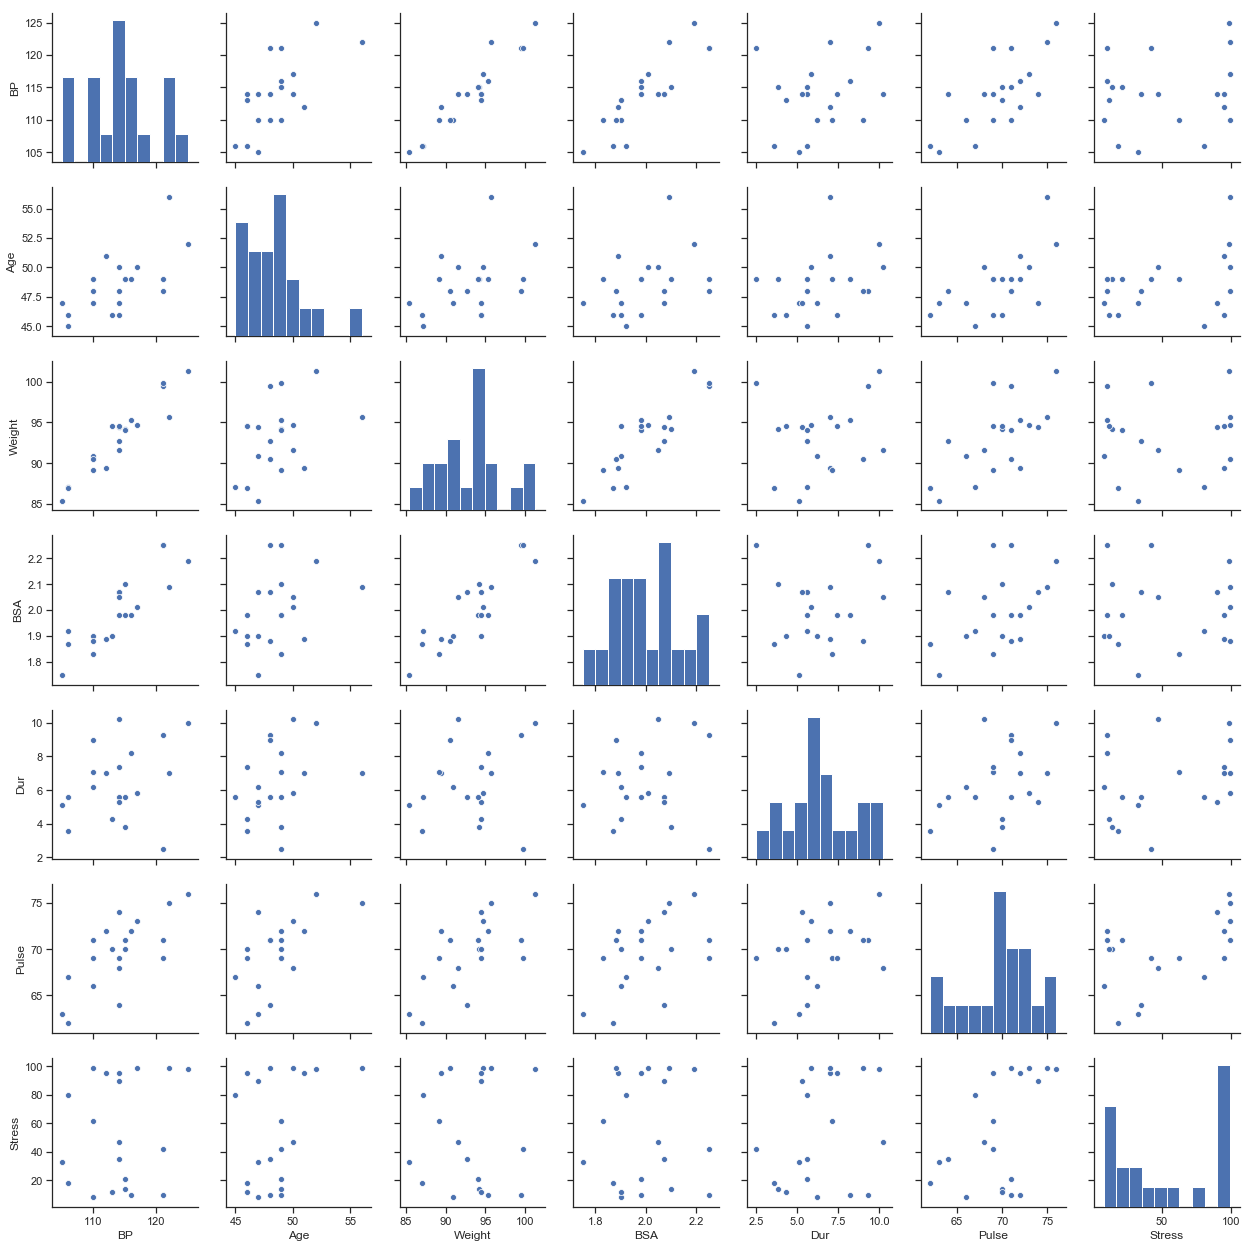

In [149]:
sns.set(style="ticks")
sns.pairplot(bp[[x for x in bp.columns if x != 'Pt']])

Let's focus on the relationships among the response $y = BP$ and the predictors $x_2 = Weight$ and $x_3 = BSA$:

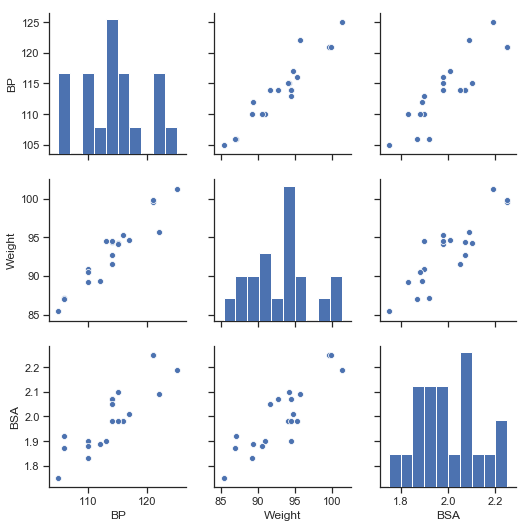

In [150]:
sns.set(style="ticks")
sns.pairplot(bp[['BP', 'Weight', 'BSA']])

There appears to be not only a strong relationship between $y = BP$ and $x_2 = Weight$ and a strong relationship between $y = BP$ and the predictor $x_3 = BSA$, but also a strong relationship between the two predictors $x_2$ = Weight and $x_3 = BSA$.

The regression of the response $y = BP$ on the predictor $x_2= Weight$:

In [151]:
bp_weight = sm.OLS(bp['BP'], sm.add_constant(bp['Weight'])).fit()
bp_weight.summary()

/Users/charlessmcallister/.local/share/virtualenvs/learning-data-science-Oygx0A85/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     BP   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     166.9
Date:                Mon, 22 Apr 2019   Prob (F-statistic):           1.53e-10
Time:                        13:11:33   Log-Likelihood:                -38.409
No. Observations:                  20   AIC:                             80.82
Df Residuals:                      18   BIC:                             82.81
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2053      8.663      0.255      0.802     -15.996      20.406
Weight         1.2009      0.093     12.917      0.000       1.006       1.396
==============================================================================
Omnibus:                        9.231   Durbin-Watson:                   1.641
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                6.566
Skew:                           1.157   Prob(JB):                       0.0375
Kurtosis:                       4.590   Cond. No.                     2.07e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.07e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Above, the estimated coefficient $b_2 = 1.2009$, the standard error $se(b_2) = 0.093$. And the regression sum of squares is:

In [152]:
bp_weight.ess

505.47198397616984

The regression of the response $y = BP$ on the predictor $x_3= BSA$:

In [153]:
bp_bsa = sm.OLS(bp['BP'], sm.add_constant(bp['BSA'])).fit()
bp_bsa.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     BP   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     53.93
Date:                Mon, 22 Apr 2019   Prob (F-statistic):           8.11e-07
Time:                        13:11:33   Log-Likelihood:                -47.848
No. Observations:                  20   AIC:                             99.70
Df Residuals:                      18   BIC:                             101.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         45.1833      9.392      4.811      0.000      25.452      64.915
BSA           34.4428      4.690      7.343      0.000      24.589      44.297
==============================================================================
Omnibus:                        0.405   Durbin-Watson:                   2.130
Prob(Omnibus):                  0.817   Jarque-Bera (JB):                0.520
Skew:                           0.008   Prob(JB):                        0.771
Kurtosis:                       2.210   Cond. No.                         37.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

above, the estimated coefficient $b_3 = 34.44$, the standard error $se(b_3) = 4.69$, and the regression sum of squares is:

In [154]:
bp_bsa.ess

419.8578774864376

Finally, the regression of the response $y = BP$ on the predictors $x_2= Weight$ and $x_3 = BSA$ (in that order):

In [155]:
bp_weight_bsa = sm.OLS(bp['BP'], sm.add_constant(bp[['Weight', 'BSA']])).fit()
bp_weight_bsa.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     BP   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     83.54
Date:                Mon, 22 Apr 2019   Prob (F-statistic):           1.61e-09
Time:                        13:11:34   Log-Likelihood:                -37.879
No. Observations:                  20   AIC:                             81.76
Df Residuals:                      17   BIC:                             84.74
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6534      9.392      0.602      0.555     -14.163      25.470
Weight         1.0387      0.193      5.392      0.000       0.632       1.445
BSA            5.8313      6.063      0.962      0.350      -6.960      18.622
==============================================================================
Omnibus:                        9.750   Durbin-Watson:                   1.639
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                7.071
Skew:                           1.264   Prob(JB):                       0.0292
Kurtosis:                       4.446   Cond. No.                     2.34e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.34e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

yields the estimated coefficients $b_2 = 1.039$ and $b_3 = 5.83$, the standard errors $se(b_2) = 0.193$ and $se(b_3) = 6.06$, and the sequential sum of squares $SSR(x_{3}\mid x_{2})$ of $2.814$:

In [156]:
#Sequential sum of squares is a useful procedure for choosing which variables to use in a model, and an 
#analysis of variance (ANOVA) will give us the sums of squares per each predictor that we need to do it. 
#It partitions the SSR — the proportion of the variability in the target variable that is explained 
#by the linear relationship of the target variable with the set of predictor variables — 
#into the unique portions of the SSR that are explained by the particular predictors, given any earlier predictors. 
bp_weight_bsa = smf.ols(formula='BP ~ Weight + BSA', data = bp).fit()
anova_lm(bp_weight_bsa)

,df,sum_sq,mean_sq,F,PR(>F)
Weight,1.0,505.471984,505.471984,166.164849,3.340647e-10
BSA,1.0,2.814168,2.814168,0.925107,3.496199e-01
Residual,17.0,51.713848,3.041991,NaN,NaN


And finally, the regression of the response $y = BP$ on the predictors $x_3= BSA$ and $x_2= Weight$ (in that order):

In [157]:
bp_bsa_weight = smf.ols(formula='BP ~ BSA + Weight', data = bp).fit()
print(bp_bsa_weight.summary())
print(anova_lm(bp_weight_bsa))

                            OLS Regression Results                            
Dep. Variable:                     BP   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     83.54
Date:                Mon, 22 Apr 2019   Prob (F-statistic):           1.61e-09
Time:                        13:11:34   Log-Likelihood:                -37.879
No. Observations:                  20   AIC:                             81.76
Df Residuals:                      17   BIC:                             84.74
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.6534      9.392      0.602      0.5

yields the estimated coefficients $b_2 = 1.039$ and $b_3 = 5.83$, the standard errors $se(b_2) = 0.193$ and $se(b_3) = 6.06$, and the sequential sum of squares $SSR(x_{2}\mid x_{3}) = 88.43$

| Model | b2 | se(b2) | b3 | se(b3) | Seq SS
| --- | --- | --- | --- | --- | --- |
| x2 only | 1.2009 | 0.0930 | na | na | SSR(x2) = 505.472 |
| x3 only | na | na | 34.44 | 4.69 | SSR(x3) 419.858 |
| x2, x3(in order) | 1.039 | 0.193 | 5.83 | 6.06 | SSR(x3|x2) 2.814|
| x3, x2(in order) | 1.039 | 0.193 | 5.83 | 6.06 | SSR(x2|x3) 88.43|

It appears as if, when predictors are highly correlated, the answers you get depend on the predictors in the model. That's not good!

#### Effect #1

When predictor variables are correlated, the estimated regression coefficient of any one variable depends on which other predictor variables are included in the model. Depending on which predictors we included in the model, we obtained wildly different estimates of the slope parameter for $x_3 = BSA$:
 - If $x_3 = BSA$ is the only predictor included in our model, we claim that for every additional one square meter increase in body surface area (BSA), blood pressure (BP) increases by $34.4$ mm Hg.
 - On the other hand, if $x_2 = Weight$ and $x_3 = BSA$ are both included in our model, we claim that for every additional one square meter increase in body surface area (BSA), holding weight constant, blood pressure (BP) increases by only 5.83 mm Hg.
 
This is a huge difference! When interpreting $b_3 = 34.4$ in the model that excludes $x_2 = Weight$, keep in mind that when we increase $x_3 = BSA$ then $x_2 = Weight$ also increases and both factors are associated with increased blood pressure. However, when interpreting $b_3 = 5.83$ in the model that includes $x_2 = Weight$, we keep $x_2 = Weight$ fixed, so the resulting increase in blood pressure is much smaller. The scary thing is that even predictors that are not included in the model, but are highly correlated with the predictors in our model, can have the same impact.

#### Effect #2

When predictor variables are correlated, the precision of the estimated regression coefficients decreases as more predictor variables are added to the model.

The standard error for the estimated slope $b_2$ obtained from the model including both $x_2 = Weight$ and $x_3 = BSA$ is about double the standard error for the estimated slope $b_2$ obtained from the model including only $x_2 = Weight$. And, the standard error for the estimated slope $b_3$ obtained from the model including both $x_2 = Weight$ and $x_3 = BSA$ is about 30% larger than the standard error for the estimated slope $b_3$ obtained from the model including only $x_3 = BSA$.

What is the major implication of these increased standard errors? Recall that the standard errors are used in the calculation of the confidence intervals for the slope parameters. That is, increased standard errors of the estimated slopes lead to wider confidence intervals, and hence less precise estimates of the slope parameters. This [video](https://www.youtube.com/watch?v=v7zhxykyjag) demonstrates this problem geometrically.

#### Effect #3

When predictor variables are correlated, the marginal contribution of any one predictor variable in reducing the error sum of squares varies depending on which other variables are already in the model.

For example, regressing the response $y = BP$ on the predictor $x_2 = Weight$, we obtain $SSR(x_2) = 505.472$. But, regressing the response $y = BP$ on the two predictors $x_3 = BSA$ and $x_2 = Weight$ (in that order), we obtain $SSR(x_{2}\mid x_{3}) = 88.43$. The first model suggests that weight reduces the error sum of squares substantially (by $505.472$), but the second model suggests that weight doesn't reduce the error sum of squares all that much (by $88.43$) once a person's body surface area is taken into account.

This should make intuitive sense. In essence, weight appears to explain some of the variation in blood pressure. However, because weight and body surface area are highly correlated, most of the variation in blood pressure explained by weight could just have easily been explained by body surface area. Therefore, once you take into account a person's body surface area, there's not much variation left in the blood pressure for weight to explain.

Incidentally, we see a similar phenomenon when we enter the predictors into the model in the reverse order. That is, regressing the response $y = BP$ on the predictor $x_3 = BSA$, we obtain $SSR(x_3) = 419.858$. But, regressing the response $y = BP$ on the two predictors $x_2 = Weight$ and $x_3 = BSA$ (in that order), we obtain $SSR(x_{3}\mid x_{2}) = 2.814$. The first model suggests that body surface area reduces the error sum of squares substantially (by $419.858$), and the second model suggests that body surface area doesn't reduce the error sum of squares all that much (by only $2.814$) once a person's weight is taken into account.

#### Effect #4

When predictor variables are correlated, hypothesis tests for $\beta_k = 0$ may yield different conclusions depending on which predictor variables are in the model. (This effect is a direct consequence of the three previous effects.)

To illustrate this effect, let's once again quickly proceed through the output of a series of regression analyses, focusing primarily on the outcome of the t-tests for testing $H_0 : \beta_{BSA} = 0$ and $H_0 : \beta_{Weight} = 0$.

The regression of the response $y = BP$ on the predictor $x_3 = BSA$:

In [158]:
bp_bsa = smf.ols('BP ~ BSA', data = bp).fit()
print(bp_bsa.summary())

                            OLS Regression Results                            
Dep. Variable:                     BP   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     53.93
Date:                Mon, 22 Apr 2019   Prob (F-statistic):           8.11e-07
Time:                        13:11:34   Log-Likelihood:                -47.848
No. Observations:                  20   AIC:                             99.70
Df Residuals:                      18   BIC:                             101.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     45.1833      9.392      4.811      0.0

The summary indicates that the P-value associated with the t-test for testing $H_0 : \beta_{BSA} = 0$ is 0.000... < 0.01. There is sufficient evidence at the 0.05 level to conclude that blood pressure is significantly related to body surface area.

The regression of the response $y = BP$ on the predictor $x_2 = Weight$:

In [159]:
bp_weight.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     BP   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     166.9
Date:                Mon, 22 Apr 2019   Prob (F-statistic):           1.53e-10
Time:                        13:11:34   Log-Likelihood:                -38.409
No. Observations:                  20   AIC:                             80.82
Df Residuals:                      18   BIC:                             82.81
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2053      8.663      0.255      0.802     -15.996      20.406
Weight         1.2009      0.093     12.917      0.000       1.006       1.396
==============================================================================
Omnibus:                        9.231   Durbin-Watson:                   1.641
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                6.566
Skew:                           1.157   Prob(JB):                       0.0375
Kurtosis:                       4.590   Cond. No.                     2.07e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.07e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This summary indicates that the P-value associated with the t-test for testing $H_0 : \beta_{Weight} = 0$ is $0.000... < 0.01$. There is sufficient evidence at the $0.05$ level to conclude that blood pressure is significantly related to weight.

And, the regression of the response $y = BP$ on the predictors $x_2 = Weight$ and $x_3 = BSA$:

In [160]:
bp_weight_bsa.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     BP   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     83.54
Date:                Mon, 22 Apr 2019   Prob (F-statistic):           1.61e-09
Time:                        13:11:34   Log-Likelihood:                -37.879
No. Observations:                  20   AIC:                             81.76
Df Residuals:                      17   BIC:                             84.74
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.6534      9.392      0.602      0.555     -14.163      25.470
Weight         1.0387      0.193      5.392      0.000       0.632       1.445
BSA            5.8313      6.063      0.962      0.350      -6.960      18.622
==============================================================================
Omnibus:                        9.750   Durbin-Watson:                   1.639
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                7.071
Skew:                           1.264   Prob(JB):                       0.0292
Kurtosis:                       4.446   Cond. No.                     2.34e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.34e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This indicates that the P-value associated with the t-test for testing $H_0 : \beta_{Weight} = 0$ is $0.000... < 0.01$. There is sufficient evidence at the $0.05$ level to conclude that, after taking into account body surface area, blood pressure is significantly related to weight.

The regression also indicates that the P-value associated with the t-test for testing $H_0 : \beta_{BSA} = 0$ is $0.350$. There is insufficient evidence at the $0.05$ level to conclude that blood pressure is significantly related to body surface area after taking into account weight. This might sound contradictory to what we claimed earlier, namely that blood pressure is indeed significantly related to body surface area. Again, what is going on here, once you take into account a person's weight, body surface area doesn't explain much of the remaining variability in blood pressure readings.

#### Effect #5
High multicollinearity among predictor variables does not prevent good, precise predictions of the response within the scope of the model. If the primary purpose of your regression analysis is to estimate a mean response $\mu_Y$ or to predict a new response $y$, you don't have to worry much about multicollinearity.


#### The bottom line
In the presence of multicollinearity:

 - It is okay to use an estimated regression model to predict $y$ or estimate $\mu_Y$ as long as you do so within the scope of the model.
 - We can no longer make much sense of the usual interpretation of a slope coefficient as the change in the mean response for each additional unit increase in the predictor $x_k$, **when all the other predictors are held constant.** It just doesn't make sense to talk about holding the values of correlated predictors constant, since changing one predictor necessarily would change the values of the others.

In order to get a handle on this multicollinearity, let's first investigate the effects that uncorrelated predictors have on regression analyses. To do so, we'll investigate a "contrived" data set, in which the predictors are **perfectly uncorrelated**. Then, we'll investigate a second example of a "real" data set, in which the predictors are **nearly uncorrelated**. Our two investigations will allow us to summarize the effects that uncorrelated predictors have on regression analyses.

In [161]:
a = np.arange(10)
b = a + 2

If we were to fit a model using both of these variables, our estimate for either $\beta$ would be meaningless. $\beta_a$, for example, is the change in the dependent variable associated with a one unit change in $a$ *holding $b$ constant*. But if you hold $b$ constant, then $a$ doesn't change because they are perfectly colinear. Although the OLS will output an estimate for $\beta_a$, it is in fact undefined. The solution in such a situation is to drop one of the colinear variables.

#### A more formal definition
The regressors in $X$ must all be [linearly independent](https://en.wikipedia.org/wiki/Linear_independence). Mathematically, this means that the matrix X must have full [column rank](https://en.wikipedia.org/wiki/Rank_(linear_algebra)#Main_definitions) almost surely: $\Pr\!\big[\,\operatorname{rank}(X) = p\,\big] = 1$. Usually, it is also assumed that the regressors have finite moments up to at least the second moment. Then the matrix $Q_{xx} = E[X^TX/n]$ is finite and positive semi-definite. When this assumption is violated the regressors are called linearly dependent or perfectly multicollinear. In such case the value of the regression coefficient $\beta$ cannot be learned, although prediction of $y$ values is still possible for new values of the regressors that lie in the same linearly dependent subspace.

#### The effect of perfect multicollinearity
Severe multicollinearity is a problem because it can increase the variance of the coefficient estimates and make the estimates very sensitive to minor changes in the model. The result is that the coefficient estimates are unstable and difficult to interpret. Multicollinearity saps the statistical power of the analysis, can cause the coefficients to switch signs, and makes it more difficult to specify the correct model.

In our OLS equation, the product $N=X^{T}X$ is a [normal matrix](https://en.wikipedia.org/wiki/Normal_matrix) and its inverse, $Q=N^{–1}$, is the cofactor matrix of $\beta$, which is closely related to its covariance matrix, $C_\beta$. Together, the matrix $(X^{T}X)^{–1}X^T = QX^{T}$ is called the [Moore–Penrose pseudoinverse](https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse) matrix of $X$. This formulation highlights the point that estimation can be carried out if, and only if, there is no perfect multicollinearity between the explanatory variables (which would cause the normal matrix to have no inverse).

To see how the presence of multicollinearity pans out, we'll try to calculate $Q$ after adding a linearly dependent column to our design matrix $X$.

In [162]:
#make the normal matrix with the data as-is
normal_matrix = np.dot(X_T, X)

Now, if we were to introduce a new column vector into our matrix $X$ that is perfectly colinear with another column vector in $X$, we'll see that we can no logner calculate the inverse of the $X^{T}X$

In [163]:
# add a linearly dependent column to X
X_colinear = np.column_stack((X, X[:,1] + 2))
#calculate correlation matrix to show perfect correlation between columns 1 and 3
pd.DataFrame(X_colinear).corr()

,0,1,2,3
0,NaN,NaN,NaN,NaN
1,NaN,1.000000,0.967944,1.000000
2,NaN,0.967944,1.000000,0.967944
3,NaN,1.000000,0.967944,1.000000


In [164]:
X_colinear_T = np.transpose(X_colinear)
normal_matrix_colinear = np.dot(X_colinear_T, X_colinear)

In [165]:
def singular_matrix_test(X):
    '''
    Numpy will invert singular matrices containing floating points due to rounding errors, so we'll
    test if the condition of the matrix (the ratio of the largest singular value of that matrix 
    to the smallest singular value) is less than 1/np.finfo(X.dtype).eps, where the denominator is 
    has the precision of the array's dtype, which may differ from sys.float_info.epsilon.
    
    '''
    if np.linalg.cond(X) < 1/np.finfo(X.dtype).eps:
        i = np.linalg.inv(X)
    else:
        print("likely singular")
        return
        
    return i

In [166]:
singular_matrix_test(normal_matrix)

array([[ 4.41118664e-02, -1.76003399e-02,  1.46301906e-03],
       [-1.76003399e-02,  9.41647814e-03, -8.82244829e-04],
       [ 1.46301906e-03, -8.82244829e-04,  8.82244829e-05]])

In [167]:
singular_matrix_test(normal_matrix_colinear)

likely singular


Because of floating point precision, we can still calculate $Q$ and create an OLS model. Because of this, it's important to know how to spot multicollinearity. Fortunately, there are two measures of that we can use.

### Measuring Multicolinearity

There are two common measures of multicolinearity:  the **variance inflation factor (VIF)** and the **condition number**

#### Variance Inflation Factor
The variance inflation factor is the ratio of variance in a model with multiple terms, divided by the variance of a model with one term alone. It quantifies the severity of multicollinearity in an ordinary least squares regression analysis. It provides an index that measures how much the variance (the square of the estimate's standard deviation) of an estimated regression coefficient is increased because of collinearity.

We can calculate the VIF for each of our regressors like this:

In [168]:
#note that variance_inflation_factor expects the presence of a constant in the matrix of explanatory variables
vif = [variance_inflation_factor(X, i) for i in range(1, X.shape[1])]
print(vif)

[15.851860186018582, 15.85186018601861]


In [169]:
#and with the perfectly colinear data, which will return infinity!
vif = [variance_inflation_factor(X_colinear, i) for i in range(1, X.shape[1])]
print(vif)

[inf, 15.85186018601861]


Above, a VIF of $15$ means that the variance (a measure of imprecision) of the estimated coefficient is $15$ times higher because of correlation between the two independent variables. 


#### When is multicollinearity a problem?
Testing for the signs of multicollinearity becomes important when you want to interpet the impact of a single independent variable by looking at its coefficient $\beta$. When we test whether a coefficient $\beta_i$ is significant, we're performing a statistical hypothesis test

$$
𝐻_0:\beta_𝑖=0$ versus $𝐻_1:\beta_𝑖≠0
$$

If $𝐻_0$ is true, then the estimator $\hat{\beta}_i$ follows a normal distribution with mean $0$, i.e. if $𝐻_0$ is true then $\hat{\beta}_i \sim N(0;\sigma_{\hat{\beta}_i})$.

The value for $\beta_i$ that we compute from our sample comes from this distribution, therefore $\frac{|\bar{\beta}_i - 0|}{\sigma_{\hat{\beta}_i}}$ is an outcome of a standard normal random variable. So for a significance level $\alpha$ we will reject the $𝐻_0$ whenever $\frac{|\bar{\beta}_i | }{\sigma_{\hat{\beta}_i}} \ge z_{\frac{\alpha}{2}}$

If there is correlation between your independent variables $𝑥_1$ and $𝑥_2$ then it can be shown that $\sigma_{\hat{\beta}_i}$ will be larger than when $𝑥_1$ and $𝑥_2$ are uncorrelated. That's because $x_1$ and $x_2$ 'move together' when they are strongly correlated. What linear regression tries to do is to 'assign' a change in the dependent variable $𝑦$ to either $𝑥_1$ or $𝑥_2$. Obviously, if both 'move together' (because of high correlation) then it will be difficult to 'decide' which of the $𝑥$'s is 'responsible' for the change in $𝑦$ (because they both change). Therefore the estimates of the $𝛽_𝑖$ coefficients will be less precise. Therefore, if $𝑥_1$ and $𝑥_2$ are correlated, the null hypothesis will be 'more difficult to reject' because of the higher denominator.

The Variance Inflating Factor (VIF) tells you how much higher the variance $\sigma_{\hat{\beta}_i}$ are when $𝑥_1$ and $𝑥_2$ are correlated compared to when they are uncorrelated. 


All of this isn't a problem if your goal is to make predictions, as the precision/accuracy of those won't be affected. But if you want to analyse the impact of a single independent variable, then there may be a problem because the estimates of the coefficients are imprecise (i.e. if you would estimate them with another sample then they may change a lot).

#### Condition Number

The condition number associated with the linear equation $Ax = b$ gives a bound on how inaccurate the solution $x$ will be after approximation. Note that this is before the effects of round-off error are taken into account; conditioning is a property of the matrix, not the algorithm or floating point accuracy of the computer used to solve the corresponding system. 

Very roughly, the condition number is the rate at which the solution, $x$, will change with respect to a change in $b$. Thus, if the condition number is large, even a small error in $b$ may cause a large error in $x$. On the other hand, if the condition number is small then the error in $x$ will not be much bigger than the error in $b$.
More precisely, the condition number is the maximum ratio of the relative error in x to the relative error in b. We used it above in comparison with our machine's floating point precision to determine that our perfeclty colinear matrix was in fact singular. 

As a rule of thumb, if the condition number $\kappa(A) = 10^k$, then you may lose up to $k$ digits of accuracy on top of what would be lost to the numerical method due to loss of precision from arithmetic methods. However, the condition number does not give the exact value of the maximum inaccuracy that may occur in the algorithm. It generally just bounds it with an estimate (whose computed value depends on the choice of the norm to measure the inaccuracy).

If we use `statsmodels` to run an OLS with data that has multicolinearity issues, it'll let you know by adding an error about either the conidtion number being to high or the smallest eigenvalue being too small:

In [170]:
col_ols = sm.OLS(y, X_colinear).fit()
col_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.067e+06
Date:                Mon, 22 Apr 2019   Prob (F-statistic):               0.00
Time:                        13:11:34   Log-Likelihood:                -293.19
No. Observations:                 200   AIC:                             592.4
Df Residuals:                     197   BIC:                             602.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2351      0.105      2.242      0.026       0.028       0.442
x1            -0.1380      0.154     -0.897      0.371      -0.441       0.165
x2             9.9890      0.010   1006.994      0.000       9.969      10.009
x3             0.3323      0.060      5.556      0.000       0.214       0.450
==============================================================================
Omnibus:                        0.456   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.796   Jarque-Bera (JB):                0.514
Skew:                          -0.112   Prob(JB):                        0.774
Kurtosis:                       2.894   Cond. No.                     5.05e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.64e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### 7. Normality
It is sometimes additionally assumed that the errors have normal distribution conditional on the regressors: $$\varepsilon \mid X\sim \mathcal{N}(0, \sigma^2I_n)$$ This assumption is not needed for the validity of the OLS method, although certain additional finite-sample properties can be established in case when it does (especially in the area of hypotheses testing). Also when the errors are normal, the OLS estimator is equivalent to the maximum likelihood estimator (MLE), and therefore it is asymptotically efficient in the class of all regular estimators. Importantly, the normality assumption applies only to the error terms; contrary to a popular misconception, the response (dependent) variable is not required to be normally distributed.

We can visually inspect this assumption with a Q-Q Plot:

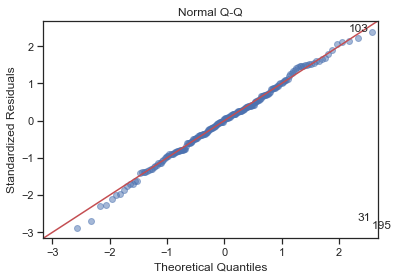

In [171]:
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]
for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i,
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]));

A good normal QQ plot has all of the residuals lying on or close to the red line.

## OLS Properties
When assumptions 1-6 are satisfied, we can say that our OLS model has the following properties:

1. **Linear** - OLS estimators are linear functions of the values of $Y$ (the dependent variable) which are linearly combined using weights that are a non-linear function of the values of $X$ (the regressors or explanatory variables). So the OLS estimator is a "linear" estimator with respect to how it uses the values of the dependent variable only, and irrespective of how it uses the values of the regressors.
2. **Unbiased** - Suppose that the *population* size is $100$. We use samples of size $10$ to estimate the $\alpha$  and $\beta$ of the population. Everytime we use a different sample (a different set of $10$ unique parts of the population), we will get a different $\alpha$ and $\beta$. If our assumptions are met, the mean parameter values of repeated resampling and OLS estimations will give you the population values for $\alpha$ and $\beta$. That is, $\operatorname{E}(\hat{\boldsymbol{\beta}}) = (\beta)$.
3. **Efficient** - This means OLS has the minimum variance of all other approaches. (Variance is a measure of how far the different $\alpha$ and $\beta$ are from their true population mean.)
 - An estimator that is unbiased but does not have the minimum variance is not good.
 - An estimator that has the minimum variance but is biased is not good
 - An estimator that is unbiased and has the minimum variance of all other estimators is the best (efficient).
4. **Consistent** - A consistent estimator is one which approaches the real value of the parameter in the population as the size of the sample, $n$, increases.

## Outliers, Influence and Leverage
All of the OLS assumptions can be met, but you may still end up with a error-laden model if your sample data contains problematic points:

 - **Outliers**: an outlier is defined as an observation that has a large residual. In other words, the observed value for the point is very different from that predicted by the regression model.
 - **Leverage points**: A leverage point is defined as an observation that has a value of x that is far away from the mean of x. 
 - **Influential observations**: An influential observation is defined as an observation that changes the slope of the line. Thus, influential points have a large influence on the fit of the model. One method to find influential points is to compare the fit of the model with and without each observation.


### Leverage
The matrix formulation of our OLS regression can be written as:

$$
Y=X\beta+\epsilon
$$

Therefore, the predicted responses can be represented in matrix notation as:

$$
\hat{y}=Xb
$$

And the estimated coefficients are represented in matrix notation as:

$$
b = (X^{'}X)^{-1}X^{'}y
$$

Thus the predicted responses can be alternatively written as:

$$
\hat{y}=X(X^{'}X)^{-1}X^{'}y
$$

That is, the predicted responses can be obtained by pre-multiplying the $n × 1$ column vector, $y$, containing the observed responses by the $n × n$ matrix $H$:

$$
H=X(X^{'}X)^{-1}X^{'}
$$

That is,

$$
\hat{y}=Hy
$$

Again, statisticians often call this $n × n$ matrix $H$ "the hat matrix" because it's the matrix that puts the hat ($ˆ$) on the observed response vector $y$ to get the predicted response vector $\hat{y}$. **This is important for calculating leverage because $H$ contains the "leverages" that help us identify extreme $x$ values.**

If we actually perform the matrix multiplication on the right side of this equation:

$$
\hat{y}=Hy
$$

we can see that the predicted response for observation $i$ can be written as a linear combination of the $n$ observed responses $y_1$, $y_2$, ..., $y_n$:

$$
\hat{y}_i=h_{i1}y_1+h_{i2}y_2+...+h_{ii}y_i+ ... + h_{in}y_n  \;\;\;\;\; \text{ for } i=1, ..., n
$$

Above, the weights $h_{i1}, h_{i2}, ..., h_{ii}, ..., h_{in}$ depend only on the predictor values. That is:

$$
\hat{y}_1=h_{11}y_1+h_{12}y_2+\cdots+h_{1n}y_n
$$
$$
\hat{y}_2=h_{21}y_1+h_{22}y_2+\cdots+h_{2n}y_n
$$
<br>
$$
\hat{y}_n=h_{n1}y_1+h_{n2}y_2+\cdots+h_{nn}y_n
$$

Because the predicted response can be written as:

$$
\hat{y}_i=h_{i1}y_1+h_{i2}y_2+...+h_{ii}y_i+ ... + h_{in}y_n  \;\;\;\;\; \text{ for } i=1, ..., n
$$

the leverage, $h_{ii}$, quantifies the influence that the observed response $y_i$ has on its predicted value $\hat{y_i}$. That is, if ${h_ii}$ is small, then the observed response $y_i$ plays only a small role in the value of the predicted response $\hat{y_i}$. On the other hand, if $h_{ii}$ is large, then the observed response $y_i$ plays a large role in the value of the predicted response $\hat{y_i}$. It's for this reason that the hii are called the "leverages."

How do we know when a leverage value is too large? A common rule is to flag any observation whose leverage value, $h_{ii}$, is more than $3$ times larger than the mean leverage value:

$$
\bar{h}=\frac{\sum_{i=1}^{n}h_{ii}}{n}=\frac{p}{n}
$$

That is, if:

$$
h_{ii} >3\left( \frac{p}{n}\right)
$$

Then we should flag the observation as a leverage point.

We'll work this out with some toy data that actually contains a leverage point.

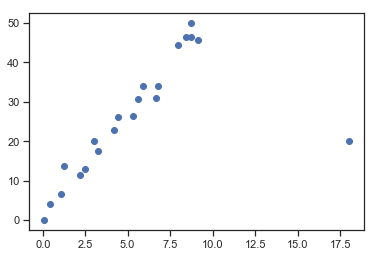

In [172]:
df = pd.read_csv('assets/leverage.txt',
                 delim_whitespace=True, 
                 names=('Row', 'x', 'y')).iloc[1:]
df = df.astype(float)
df = sm.add_constant(df)
plt.scatter(df['x'], df['y'])

We can see our levarage point way off to the right there $(x = 18, y = 20)$. 
There are $n = 21$ data points and $p = 2$ parameters (with intercept $\beta_0$ and slope $\beta_1$). Therefore:

$$
3\left( \frac{p}{n}\right)=3\left( \frac{2}{21}\right)=0.286
$$

Any observation with a leverage greater than $0.286$ would be a leverage point. In order to calculate our leverage, let's fit a model and then access that method on the OLS object:

In [173]:
lev_model = sm.OLS(df['y'], df[['const', 'x']]).fit()
# we can get the leverage for each observation like this
model_leverage = lev_model.get_influence().hat_matrix_diag
np.where(model_leverage > 0.286)

(array([20]),)

### Outliers
Ordinary residuals are defined for each observation, $i = 1, ..., n$ as the difference between the observed and predicted responses:

$$
e_i=y_i-\hat{y}_i
$$

A major problem with interpreting residuals is that their magnitude depends on the units of measurement, thereby making it difficult to use the residuals as a way of detecting unusual $y$ values. We can eliminate the units of measurement by dividing the residuals by an estimate of their standard deviation, thereby obtaining what are known as **studentized residuals** (also called internally studentized residuals).

#### Studentized residuals (or internally studentized residuals)
Studentized residuals (or internally studentized residuals) are defined for each observation, $i = 1, ..., n$ as an ordinary residual divided by an estimate of its standard deviation:

$$
r_{i}=\frac{e_{i}}{s(e_{i})}=\frac{e_{i}}{\sqrt{MSE(1-h_{ii})}}
$$

Here, we see that the internally studentized residual for a given data point depends not only on the ordinary residual, but also the size of the mean square error (MSE) and the leverage $h_{ii}$.

As a result, studentized residuals quantify how large the residuals are in standard deviation units, and therefore can be easily used to identify outliers:

 - An observation with an internally studentized residual that is larger than 3 (in absolute value) is generally deemed an outlier. Sometimes, the term "outlier" is reserved for an observation with an *externally* studentized residual that is larger than 3 in absolute value (we'll consider externally studentized residuals in the next section).

To see the outliers in the leverage data we imported, we can again use the influence instance:

In [175]:
infl = lev_model.get_influence()
np.where(np.abs(infl.resid_studentized_internal) > 3)

(array([20]),)

#### Why should we care about outliers?
The easiest way to understand the impact of outliers is to analyze a data set twice — once with and once without the outlier—and to observe differences in the results.

If we regress $y$ on $x$ using the data set without the outlier, we obtain:

In [176]:
model_no_outlier = sm.OLS(df['y'].iloc[:-1], 
                          df[['const', 'x']].iloc[:-1]).fit()
model_no_outlier.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     652.8
Date:                Mon, 22 Apr 2019   Prob (F-statistic):           1.35e-15
Time:                        13:12:31   Log-Likelihood:                -46.374
No. Observations:                  20   AIC:                             96.75
Df Residuals:                      18   BIC:                             98.74
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7322      1.121      1.546      0.140      -0.622       4.086
x              5.1169      0.200     25.551      0.000       4.696       5.538
==============================================================================
Omnibus:                        0.394   Durbin-Watson:                   2.066
Prob(Omnibus):                  0.821   Jarque-Bera (JB):                0.287
Skew:                           0.259   Prob(JB):                        0.866
Kurtosis:                       2.723   Cond. No.                         11.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

And if we regress $y$ on $x$ using the full data set with the outlier, we obtain:

In [177]:
lev_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     12.66
Date:                Mon, 22 Apr 2019   Prob (F-statistic):            0.00210
Time:                        13:12:32   Log-Likelihood:                -80.895
No. Observations:                  21   AIC:                             165.8
Df Residuals:                      19   BIC:                             167.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.2969      4.411      3.014      0.007       4.065      22.529
x              2.3333      0.656      3.558      0.002       0.961       3.706
==============================================================================
Omnibus:                       10.455   Durbin-Watson:                   0.898
Prob(Omnibus):                  0.005   Jarque-Bera (JB):                8.352
Skew:                          -1.158   Prob(JB):                       0.0154
Kurtosis:                       5.044   Cond. No.                         11.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The presence of the outlier did a few things, but the biggest effect is on the models' mean squared errors (this is the sum of squared residuals divided by the residual degrees of freedom). 

In [178]:
model_no_outlier.mse_resid

6.71840030424511

In [179]:
lev_model.mse_resid

143.527963946104

The [mean square error (MSE)](https://en.wikipedia.org/wiki/Mean_squared_error) is substantially inflated from $6.72$ to $143.53$ by the presence of the outlier. Recalling that MSE appears in all of our confidence and prediction interval formulas, the inflated size of MSE would thereby cause a detrimental increase in the width of all of our confidence and prediction intervals.

Although including the outlier substantially inflated our coefficent's standard error from $0.107$ to $0.461$ (and the coefficient itself is also quite different), the predicted responses, estimated slope coefficients, and hypothesis test results are not necessarily affected by the inclusion of an outlier. 

In fact, an outlier can sometimes be so extreme that its influence on the regression model is so great that the estimated regression function is "pulled" towards the potential outlier, so that it isn't flagged as an outlier using the standardized residual criterion. To address this issue, **deleted residuals** offer an alternative criterion for identifying outliers. The basic idea is to delete the observations one at a time, each time refitting the regression model on the remaining n–1 observations. Then, we compare the observed response values to their fitted values based on the models with the ith observation deleted. This produces **(unstandardized) deleted residuals**. Standardizing the deleted residuals produces **studentized deleted residuals**, also known as **externally studentized residuals**.

#### (Unstandardized) deleted residuals
If we let:

 - $y_i$ denote the observed response for the $i^{th}$ observation, and
 - $\hat{y}_{(i)}$ denote the predicted response for the $i^{th}$ observation based on the estimated model with the $i^{th}$ observation deleted
 
then the $i^{th} (unstandardized) deleted residual is defined as:

$$
d_i=y_i-\hat{y}_{(i)}
$$

Data point $i$ being influential implies that the data point "pulls" the estimated regression line towards itself. In that case, the observed response would be close to the predicted response. But, if you removed the influential data point from the data set, then the estimated regression line would "bounce back" away from the observed response, thereby resulting in a large deleted residual. That is, a data point having a large deleted residual suggests that the data point is influential.

In general, **externally studentized residuals are going to be more effective for detecting outlying $Y$ observations than internally studentized residuals.** If an observation has an externally studentized residual that is larger than $3$ (in absolute value) we can call it an outlier.

We can access the **externally studentized residuals** with `statsmodels` like this:

In [180]:
np.where(np.abs(infl.get_resid_studentized_external()) > 3)

(array([20]),)

#### Leverage vs Influence

Outliers and high leverage data points have the potential to be influential, but we generally have to investigate further to determine whether or not they are actually influential. That is, does it unduly influence any part of a regression analysis, such as the predicted responses, the estimated slope coefficients, or the hypothesis test results. 

This is an important distinction because the leverage merely quantifies the potential for a data point to exert strong influence on the regression analysis. The leverage depends only on the predictor values. Whether the data point is **influential** or not also depends on the observed value of the reponse $y_i$.

### Influence

Here we'll discuss two measures for identifying influential data points:

 - Difference in fits (DFFITS)
 - Cook's distance
 
The basic idea behind each of these measures is the same, namely to delete the observations one at a time, each time refitting the regression model on the remaining $n–1$ observations. Then, we compare the results using all $n$ observations to the results with the $i^{th}$ observation deleted to see how much influence the observation has on the analysis. Analyzed as such, we are able to assess the potential impact each data point has on the regression analysis.

#### Difference in Fits (DFFITS)
The difference in fits for observation i, denoted $DFFITS_i$, is defined as:

$$
DFFITS_i=\frac{\hat{y}_i-\hat{y}_{(i)}}{\sqrt{MSE_{(i)}h_{ii}}}
$$

As you can see, the numerator measures the difference in the predicted responses obtained when the $i_{th}$ data point is included and excluded from the analysis. The denominator is the estimated standard deviation of the difference in the predicted responses. Therefore, the difference in fits quantifies the number of standard deviations that the fitted value changes when the $i_{th}$ data point is omitted.

An observation is deemed influential if the absolute value of its DFFITS value is greater than:

$$
2\sqrt{\frac{p+1}{n-p-1}}
$$

where as always $n$ = the number of observations and $$ = the number of parameters including the intercept.

Using this guideline, we can deem a data point as being influential if the absolute value of its DFFITS value is greater than:

$$
2\sqrt{\frac{p+1}{n-p-1}}=2\sqrt{\frac{2+1}{21-2-1}}=0.82
$$

In [181]:
np.where(np.abs(infl.dffits[0]) > .82)

(array([20]),)

Above, we found our outlier that has high leverage to be an influential observation. But what to do with this observation comes down to recognizing that all of these outlier/leverage/influence measures are just tools that *flag* potentially influential data points for the data analyst. In the end, it's up to the analyst to decide if they should analyze the data set twice — once with and once without the flagged data points. If the data points significantly alter the outcome of the regression analysis, then the researcher should report the results of both analyses.

#### Cook's Distance
[Cook's distance] is defined as:

$$
D_i=\frac{(y_i-\hat{y}_i)^2}{p \times MSE}\left[ \frac{h_{ii}}{(1-h_{ii})^2}\right]
$$

The main thing to recognize is that Cook's $D_i$ depends on both the residual, $e_i$ (in the first term), and the leverage, $h_{ii}$ (in the second term). That is, both the $x$ value and the $y$ value of the data point play a role in the calculation of Cook's distance.

In short:

 - $D_i$ directly summarizes how much all of the fitted values change when the $i^{th}$ observation is deleted.
 - A data point having a large $D_i$ indicates that the data point strongly influences the fitted values.
 
When we regressed $y$ on $x$ using all $n = 20$ data points, we determined that the estimated intercept coefficient $b_0 = 13.296921$ and the estimated slope coefficient $b_1 = 2.333275$:

In [182]:
lev_model.params

const    13.296921
x         2.333275
dtype: float64

If we remove the first data point from the data set, and regress $y$ on $x$ using the remaining $n = 19$ data points, the estimated intercept coefficient $b_0$ and estimated slope coefficient $b_1$ should remain about the same:

In [183]:
model_minus_first = sm.OLS(df['y'].iloc[1:], 
                           df[['const', 'x']].iloc[1:]).fit()
model_minus_first.params

const    15.396664
x         2.083496
dtype: float64

As we would hope and expect, the estimates don't change all that much when removing the one data point. Continuing this process of removing each data point one at a time, and plotting the resulting estimated slopes ($b_1$) versus estimated intercepts ($b_0$), we obtain:

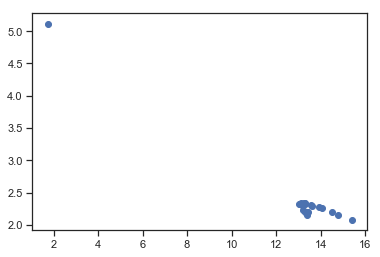

In [184]:
consts = []
slopes = []
for i in range(1, df.shape[0]+1):
    _df = df.drop([i])
    _model = sm.OLS(_df['y'], 
                    _df[['const', 'x']]).fit()
    _params = _model.params
    consts.append(_params[0])
    slopes.append(_params[1])
    
plt.scatter(consts, slopes)

As you can see, the estimated coefficients are *not* all bunched together regardless of which data point is removed. This suggests the presence of an influential observation. Let's see the model's parameters when we remove just the outlier we've identified previously:

In [185]:
model_no_outlier.params

const    1.732178
x        5.116869
dtype: float64

Wow! The constant here is estimated to be $1.73$ when it was previously estimated to be $13.296921$. And the slope is not estimated to be $5.12$ when it was previously estimated to be $2.33$. In this case, we would expect the Cook's distance measure, $D_i$, for the outlier to be large and the Cook's distance measures, $D_i$, for the remaining data points to be small. But how big is too big?

Here are the guidelines commonly used:

 - If $D_i$ is greater than $0.5$, then the $i_{th}$ data point is worthy of further investigation as it may be influential.
 - If $D_i$ is greater than $1$, then the $i_th$ data point is quite likely to be influential.
 
> An alternative method for interpreting Cook's distance that is sometimes used is to relate the measure to the $F(p, n–p)$ distribution and to find the corresponding percentile value. If this percentile is less than about $10$ or $20$ percent, then the case has little apparent influence on the fitted values. On the other hand, if it is near $50$ percent or even higher, then the case has a major influence. 

### Visualizing Influence
We can visually identify influencers with a Residuals vs Leverage plot (also called an influence plot):

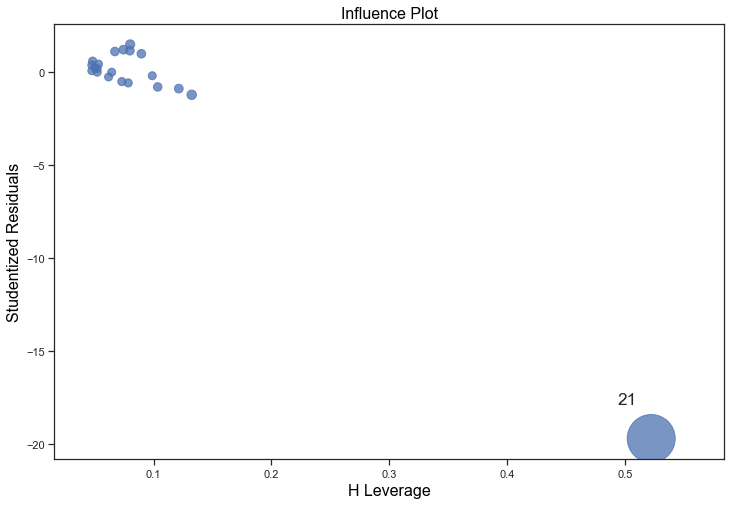

In [186]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(lev_model, ax=ax, criterion="cooks")

And what we saw above is confirmed in this plot.